In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/AI_Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls

drive  sample_data


In [ ]:
#!kaggle datasets download -d nitinsss/fashion-dataset-with-over-15000-labelled-images
!kaggle datasets download -d nitinsss/fashion-dataset-with-over-15000-labelled-images -p /content/drive/MyDrive/AI_Project

fashion-dataset-with-over-15000-labelled-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

drive  sample_data


In [ ]:
#!unzip fashion-dataset-with-over-15000-labelled-images.zip
!unzip /content/drive/MyDrive/AI_Project/fashion-dataset-with-over-15000-labelled-images.zip -d /content/drive/MyDrive/AI_Project
!ls /content/drive/MyDrive/AI_Project

Archive:  /content/drive/MyDrive/AI_Project/fashion-dataset-with-over-15000-labelled-images.zip
replace /content/drive/MyDrive/AI_Project/dress.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/drive/MyDrive/AI_Project/dress.csv  
dress.csv  fashion-dataset-with-over-15000-labelled-images.zip	kaggle.json


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AI_Project/dress.csv',on_bad_lines='skip')

In [ ]:
df.shape

(15702, 4)

In [ ]:
df.head
df.columns

Index(['_unit_id', 'category', 'category:confidence', 'image_url'], dtype='object')

In [ ]:
df['category'].unique()

array(['ikat', 'plain', 'polka dot', 'geometry', 'floral', 'squares',
       'scales', 'animal', 'OTHER', 'stripes', 'tribal', 'houndstooth',
       'cartoon', 'chevron', 'stars', 'letter_numb', 'skull'],
      dtype=object)

In [ ]:
df['category'].nunique()


17

In [ ]:
df= df[(df['category']!='OTHER')&(df['category']!='cartoon')&(df['category']!='tribal')&(df['category']!='houndstooth')]
df.shape

(14355, 4)

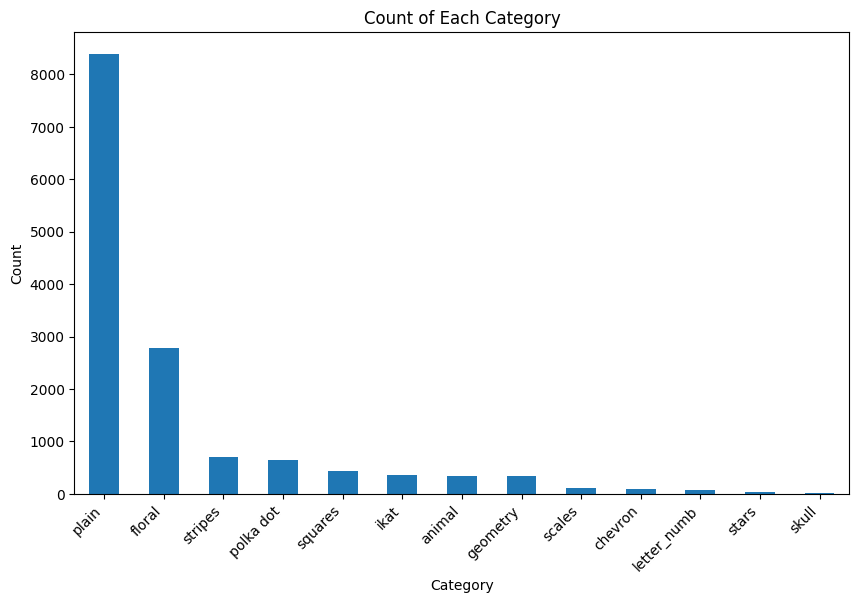

In [ ]:
import matplotlib.pyplot as plt
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Count of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
import os
import requests
import numpy as np
import cv2
import zipfile
from io import BytesIO
from PIL import Image
from multiprocessing import Pool

def process_image(image_np):
    # Read the numpy arrays as color images in OpenCV
    image_bgr = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    # Convert to HSV for creating a mask
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Create a mask that detects the red rectangular tags present in each image
    mask = cv2.inRange(image_hsv, (0, 255, 255), (0, 255, 255))

    # Get the coordinates of the red rectangle in the image,
    # But take entire image if mask fails to detect the red rectangle
    if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
    else:
        y1 = 0
        y2 = len(mask)

    if len(np.where(mask != 0)[1]) != 0:
        x1 = min(np.where(mask != 0)[1])
        x2 = max(np.where(mask != 0)[1])
    else:
        x1 = 0
        x2 = len(mask[0])

    # Crop the image along those coordinates
    image_cropped = image_bgr[y1:y2, x1:x2]
    image_resized = cv2.resize(image_cropped, (70, 70))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image_rgb)
    return image

    '''# Crop the image along those coordinates
    image_cropped = image_bgr[y1:y2, x1:x2]
    image_resized = cv2.resize(image_cropped, (70, 70))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image=Image.fromarray(image_rgb)
    return image'''

def download_image_and_save(row):
    image_url = row['image_url']
    response = requests.get(image_url)

    if response.status_code == 200:
        image_np = np.asarray(bytearray(response.content), dtype=np.uint8)
        cropped_image = process_image(image_np)

        # Save the preprocessed image directly into the in-memory zip file
        image_bytes = BytesIO()
        cropped_image.save(image_bytes, format='JPEG')
        return image_bytes.getvalue(), f"{row['category']}/{row['_unit_id']}.jpg"
    else:
        print(f"Failed to download image from URL: {image_url}")
        return None, None

def download_images_in_batch(batch_df):
    images_to_zip = []
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(download_image_and_save, [row for _, row in batch_df.iterrows()])

    for result in results:
        if result[0] is not None:
            image_bytes, zip_path = result
            images_to_zip.append((image_bytes, zip_path))

    return images_to_zip



In [ ]:
# Define output zip file name
zip_filename = 'drive/MyDrive/images_2.zip'
batch_size = 100

# Create a zip file in-memory
i=1
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for batch_idx in range(0, len(df), batch_size):
        batch_df = df.iloc[batch_idx:batch_idx + batch_size]
        images_to_zip = download_images_in_batch(batch_df)
        print(f'batch{i}')
        i+=1
        for image_bytes, zip_path in images_to_zip:
            zipf.writestr(zip_path, image_bytes)

print("All images zipped successfully.")

In [ ]:
import os
import requests
import numpy as np
import cv2
import zipfile
from io import BytesIO
from PIL import Image
from multiprocessing import Pool

def process_image(image_np):
    # Read the numpy arrays as color images in OpenCV
    image_bgr = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    # Convert to HSV for creating a mask
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Create a mask that detects the red rectangular tags present in each image
    mask = cv2.inRange(image_hsv, (0, 255, 255), (0, 255, 255))

    # Get the coordinates of the red rectangle in the image,
    # But take entire image if mask fails to detect the red rectangle
    if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
    else:
        y1 = 0
        y2 = len(mask)

    if len(np.where(mask != 0)[1]) != 0:
        x1 = min(np.where(mask != 0)[1])
        x2 = max(np.where(mask != 0)[1])
    else:
        x1 = 0
        x2 = len(mask[0])

    # Crop the image along those coordinates
    image_cropped = image_bgr[y1:y2, x1:x2]
    image_resized = cv2.resize(image_cropped, (96, 96))
    #image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image_resized)
    return image

def download_image_and_save(row):
    image_url = row['image_url']
    response = requests.get(image_url)

    if response.status_code == 200:
        image_np = np.asarray(bytearray(response.content), dtype=np.uint8)
        cropped_image = process_image(image_np)

        # Save the preprocessed image directly into the in-memory zip file
        image_bytes = BytesIO()
        cropped_image.save(image_bytes, format='JPEG')
        return image_bytes.getvalue(), f"{row['category']}/{row['_unit_id']}.jpg"
    else:
        print(f"Failed to download image from URL: {image_url}")
        return None, None

def download_images_in_batch(batch_df):
    images_to_zip = []
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(download_image_and_save, [row for _, row in batch_df.iterrows()])

    for result in results:
        if result[0] is not None:
            image_bytes, zip_path = result
            images_to_zip.append((image_bytes, zip_path))

    return images_to_zip

# Define output zip file name
zip_filename = 'drive/MyDrive/images_tuned.zip'
batch_size = 100

# Create a zip file in-memory
i=1
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for batch_idx in range(0, len(df), batch_size):
        batch_df = df.iloc[batch_idx:batch_idx + batch_size]
        images_to_zip = download_images_in_batch(batch_df)
        print(f'batch{i}')
        i+=1
        for image_bytes, zip_path in images_to_zip:
            zipf.writestr(zip_path, image_bytes)

print("All images zipped successfully.")

In [ ]:
import io
from torchvision.io import read_image
import zipfile
# Define the path to the zipped folder
zip_path = 'drive/MyDrive/images_tuned.zip'

# Define the directory where the files will be extracted
extracted_dir = 'temp2'

try:
    # Extract the zip file into the specified directory
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print("Extraction successful.")
except Exception as e:
    print("Error occurred during extraction:", str(e))

Extraction successful.


In [ ]:
import os
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from collections import Counter
from PIL import Image
import random

# Define transformations for augmentation
def augmentation_transform(image):
    # Randomly apply color jitter
    if random.random() < 0.5:
        color_jitter = transforms.ColorJitter(brightness=0.5)
        image = color_jitter(image)

    # Randomly apply rotation
    if random.random() < 0.5:
        degrees = random.uniform(-45, 45)
        image = transforms.functional.rotate(image, degrees)

    # Randomly apply horizontal flip
    if random.random() < 0.5:
        image = transforms.functional.hflip(image)

    # Randomly apply vertical flip
    if random.random() < 0.5:
        image = transforms.functional.vflip(image)

    return image

# Define the maximum number of augmented samples per class
max_augmented_samples_per_image = 5

# Create dataset from the extracted folder
dataset = ImageFolder(extracted_dir)

# Count of each class
class_counts = Counter(dataset.targets)

# Define the classes that need augmentation
classes_to_augment = [cls for cls, count in class_counts.items() if count < 1000]
dataset_classes = dataset.classes

# Augment data for classes with counts less than 1000
for cls in classes_to_augment:
    class_samples = [(img_path, label) for img_path, label in dataset.imgs if label == cls]
    for img_path, label in class_samples:
        image = Image.open(img_path)
        augmented_samples_count = min(len(class_samples), max_augmented_samples_per_image)
        for i in range(augmented_samples_count):
            augmented_image = augmentation_transform(image)
            augmented_image.save(os.path.join(extracted_dir, f'{dataset_classes[label]}/{dataset_classes[label]}_{i+1}_{os.path.basename(img_path)}'))

print("Augmentation completed.")


In [ ]:
from torchvision import transforms, datasets
from torchvision.datasets import DatasetFolder
from collections import Counter
# Define transformations
transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Create a new dataset from the augmented data

print("Original dataset size:", len(dataset))
dataset = ImageFolder(extracted_dir,transform=transform)
print(Counter(dataset.targets))

print("Augmented dataset size:", len(dataset))

In [ ]:
from torchvision import transforms, datasets
from torchvision.datasets import DatasetFolder
from collections import Counter
# Define transformations
transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Create a new dataset from the augmented data

print("Original dataset size:", len(dataset))
dataset = ImageFolder(extracted_dir,transform=transform)
print(Counter(dataset.targets))

print("Augmented dataset size:", len(dataset))

Original dataset size: 12460
Counter({6: 5451, 10: 4206, 7: 3906, 0: 3078, 11: 3042, 3: 2776, 9: 2634, 5: 2130, 1: 2112, 4: 2052, 2: 1566, 8: 672})
Augmented dataset size: 33625


In [ ]:
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch
import numpy as np
# Define the indices for train, validation, and test sets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_size = len(dataset)
indices = list(range(dataset_size))
split1 = int(np.floor(0.8 * dataset_size))  # 80% train, 20% combined validation and test
split2 = int(np.floor(0.1 * dataset_size))  # 10% validation, 10% test

# Shuffle the indices
np.random.shuffle(indices)

# Split the indices
train_indices, val_test_indices = indices[:split1], indices[split1:]
val_indices, test_indices = val_test_indices[:split2], val_test_indices[split2:]
print(train_indices)
# Define samplers for train, validation, and test sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
print(len(train_sampler))
print(len(test_sampler))
print(len(val_sampler))
# Create data loaders
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)

print("Completed")

[26615, 8165, 5995, 9188, 17967, 10827, 11762, 28212, 28691, 6655, 24384, 4752, 7209, 32663, 15548, 2755, 161, 4885, 27325, 5466, 33357, 12693, 16305, 2851, 25010, 7301, 7444, 15810, 21946, 26002, 20502, 18996, 12342, 2576, 14475, 27167, 17692, 7480, 31363, 14988, 33602, 22256, 19569, 3410, 10123, 14222, 24916, 33287, 30702, 28318, 5661, 3626, 26810, 16472, 9908, 7665, 1619, 18190, 9269, 16392, 22805, 7479, 2247, 3069, 24879, 4431, 18448, 9217, 15967, 26919, 1624, 7296, 29832, 28090, 5710, 20565, 20400, 30110, 15820, 15959, 19645, 20034, 3694, 13397, 9798, 9426, 19135, 23090, 26793, 4003, 30176, 26178, 21441, 6405, 7023, 11415, 24390, 27437, 24727, 7144, 6371, 4289, 30123, 23806, 15318, 25327, 21137, 23742, 18331, 12678, 17193, 3429, 30365, 11221, 966, 16276, 29863, 30239, 1286, 32353, 19705, 27288, 6986, 27852, 8932, 5269, 8689, 813, 22637, 590, 11343, 4159, 13977, 33191, 19291, 33312, 28126, 14801, 18540, 4228, 29166, 27123, 32536, 27604, 20073, 7019, 24560, 24732, 3973, 4658, 21320,

In [ ]:
import torchvision.models as models
import torch.nn as nn
from collections import Counter
import torch
# Define the model
model = models.resnet18(pretrained=True)  # Using MobileNetV2
#num_features = model.classifier[-1].in_features
#num_classes =  len(dataset.classes)
#model.classifier[-1] = nn.Linear(num_features, num_classes)
model = model.to(device)

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MultiLabelSoftMarginLoss()
#69.41%
#criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs=4

In [ ]:
import matplotlib.pyplot as plt
# Lists to store training and validation loss
train_losses = []
val_losses = []

# Lists to store validation accuracy
val_accuracies = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        #print(type(images))
        images = images.to(device)
        labels=labels.to(device)

        '''# Convert string labels to numerical values
        label_to_idx = {label: idx for idx, label in enumerate(set(labels))}
        labels = [label_to_idx[label] for label in labels]
        #Convert labels to tensors
        labels = labels = torch.tensor(labels, dtype=torch.long).to(device)'''


        optimizer.zero_grad()
        outputs = model(images)


        # Convert labels to tensors
        #labels = torch.tensor(labels, dtype=torch.long)  # Assuming labels are of type long
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            labels=labels.to(device)
            '''# Convert string labels to numerical values
            label_to_idx = {label: idx for idx, label in enumerate(set(labels))}
            labels = [label_to_idx[label] for label in labels]

            # Convert labels to tensors
            labels = torch.tensor(labels, dtype=torch.long).to(device)'''

            # Convert labels to tensors
            #labels = torch.tensor(labels, dtype=torch.long)  # Assuming labels are of type long
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = (correct / total) * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    val_accuracies.append(val_accuracy)

    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}, '
          f'Validation Accuracy: {(correct/total)*100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('resnet_18_Validation Accuracy')
plt.legend()
plt.show()


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('resnet_18_Training and Validation Loss')
plt.legend()
plt.show()





In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
# Testing loop
model.eval()
test_correct = 0
test_total = 0
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        true_labels.extend(labels.data.cpu().numpy())
        pred_labels.extend(predicted.data.cpu().numpy())


print(f'Test Accuracy: {(test_correct/test_total)*100:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greys)
plt.title('resnet_18_Confusion Matrix')
plt.colorbar()
classes = dataset.classes  # Assuming dataset is defined
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

'''# Build confusion matrix
classes = dataset.classes  # Assuming dataset is defined
cf_matrix = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)'''


'''# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
'''